#0.Preliminary

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
!pip install waterfallcharts
import waterfall_chart
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3389 sha256=6474b146427d70b21b4a6959ffe8901f178a15aa7f9fd8a9d8589b81e7a307ac
  Stored in directory: /root/.cache/pip/wheels/bd/34/6c/58fce34a3b8ec5607aff650db14ceb41db8223ac217423371b
Successfully built waterfallcharts


***
<br/>
<br/>
<br/>

#1.Data Cleaning and Preparation

Merge two data file to facilitate analysis of different parameters

In [4]:
whole_df=pd.read_csv('/content/master_dataset-1.csv')
headcount_df=pd.read_csv('/content/headcount.csv')
population_sex_age = pd.read_csv('/content/PopulationSexAge.csv',  encoding='ISO-8859-1', on_bad_lines='skip')
whole_df.rename(columns={'School_code': 'School Code'}, inplace=True)
headcount_df.rename(columns={'School Code': 'School Code'}, inplace=True)
merged_data = pd.merge(whole_df, headcount_df, on='School Code', how='inner') #rename the school code column into 'School Code' as index(literally, not the meanning in Python)
df = merged_data
#select the schools in metropolitan regions
df = df[df['AECG_region'].isin([ 'Metropolitan East', 'Metropolitan North', 'Metropolitan West', "Metropolitan West"])]
print(len(df))

631


Data cleaning: consider all the labels we use in this task.

In [5]:
df = df.dropna(subset=['latest_year_enrolment_FTE', 'Latitude', 'Longitude', 'HC_2018', 'HC_2023', 'School_gender', 'SA4'])


By analyzing the box plot of 'enrollment' data, we can identify the general distribution patterns, which will serve as a reference for us to establish criteria for school closures.

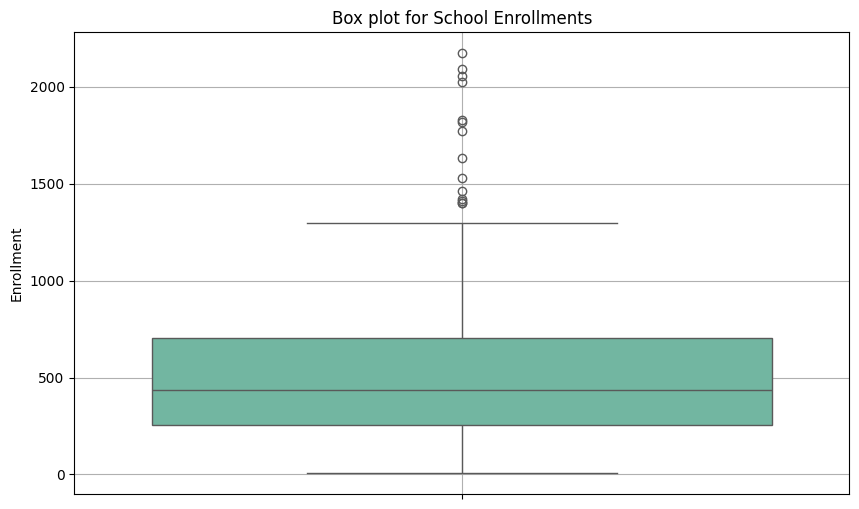

256.5
31.0
12.9375


In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='latest_year_enrolment_FTE', data=df, palette="Set2")
plt.title('Box plot for School Enrollments')
plt.ylabel('Enrollment')
plt.grid(True)
plt.show()

df = df.dropna(subset=['latest_year_enrolment_FTE'])
Q1 = np.percentile(df['latest_year_enrolment_FTE'], 25)
print(Q1)
quantile_onepercent = np.percentile(df['latest_year_enrolment_FTE'], 1)
print(quantile_onepercent)
quantile_low = np.percentile(df['latest_year_enrolment_FTE'], 0.25)
print(quantile_low)

In [7]:
Q3 = np.percentile(df['latest_year_enrolment_FTE'], 75)
IQR = Q3 - Q1
print(IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound)
print(upper_bound)

450.0
-418.5
1381.5


In this section, we establish the criteria for school closures. By identifying the nearest schools for those slated for closure, we transfer the enrollments of the closing schools to these nearby institutions and generate a new DataFrame to reflect these changes.

In [9]:
# For this calculation, we treated latitude and longitude as Cartesian coordinates,
# a simplification that will be discussed further in terms of its limitations in the shortcomings session.
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
Q_threshold = df['latest_year_enrolment_FTE'].quantile(0.25) # We take quantile 0.25% as our threshold.
low_enrollment_schools = df[df['latest_year_enrolment_FTE'] < Q_threshold]
high_enrollment_schools = df[df['latest_year_enrolment_FTE'] >= Q_threshold]

# calculate the distance and assign values
def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)
for i, low_school in low_enrollment_schools.iterrows():
    low_lat = low_school['Latitude']
    low_lon = low_school['Longitude']
    high_enrollment_schools['distance'] = high_enrollment_schools.apply(
        lambda row: calculate_distance(low_lat, low_lon, row['Latitude'], row['Longitude']),
        axis=1
    )
    nearest_high_school_idx = high_enrollment_schools['distance'].idxmin()
    high_enrollment_schools.at[nearest_high_school_idx, 'latest_year_enrolment_FTE'] += low_school['latest_year_enrolment_FTE']

# Generate a new dataframe 'df_after' to represent the data after closing those schools.
df_after = high_enrollment_schools.drop(columns=['distance']).copy()
print(len(df_after))

469


***
<br>
<br>
<br>

#2.Key Business Questions and Visulizations

##2.1 KBQ 1: How can schools with smaller enrolments be characterised?

In [10]:
#123

##2.2KBQ 2:How can schools with enrolments that are not growing (i.e. either steady or declining) be characterised?

Set up criteria for 'stable', 'growing' and 'declining' and filter the data.

In [11]:
hc_columns = ['HC_2004','HC_2005','HC_2006','HC_2007','HC_2008','HC_2009','HC_2010','HC_2011','HC_2012','HC_2013','HC_2014','HC_2015', 'HC_2016', 'HC_2017','HC_2018','HC_2020', 'HC_2021', 'HC_2022', 'HC_2023']
df[hc_columns] = df[hc_columns].apply(pd.to_numeric, errors='coerce')
df[hc_columns].dtypes
df['Average_Annual_Growth_Rate'] = (df['HC_2023'] / df['HC_2018'])**(1/5) - 1
#df['Average_Annual_Growth_Rate'].describe()
stable_enrollment = df[(df['Average_Annual_Growth_Rate']>-0.005) & (df['Average_Annual_Growth_Rate']<0.005)]
stable_enrollment.head()
growing_enrollment = df[(df['Average_Annual_Growth_Rate']>0.005)]
declining_enrollment = df[df['Average_Annual_Growth_Rate']<-0.005]

Visualization

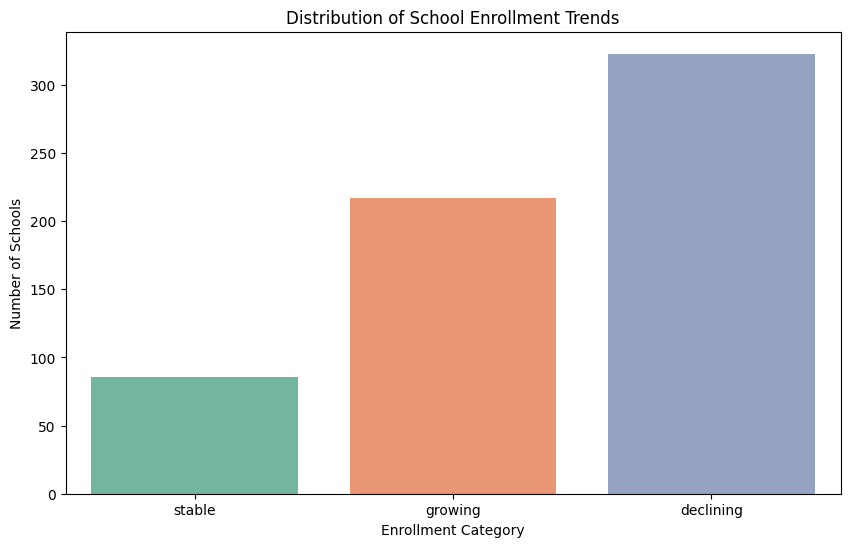

In [12]:
categories = ['stable', 'growing', 'declining']
counts = [len(stable_enrollment), len(growing_enrollment), len(declining_enrollment)]
plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts, palette="Set2")
plt.title('Distribution of School Enrollment Trends')
plt.xlabel('Enrollment Category')
plt.ylabel('Number of Schools')
plt.show()

##2.3KBQ 3:How would a policy to close schools affect school choice with regards to the gender of schools (i.e. boys schools v girls schools v coeducational schools)?

Data:Through the data, we found that coeducational schools account for the vast majority, while the number of boys' and girls' schools is relatively small. Therefore, we will visualize the three categories separately, creating three subplots.

Visualization

As we can see from the charts below, the number of boy school and girl school did not change after the implementation of our policy. Our conclusion is that this policy will not have a negative impact on families who, for reasons such as religious beliefs, need to send their children to boy school or girl school.

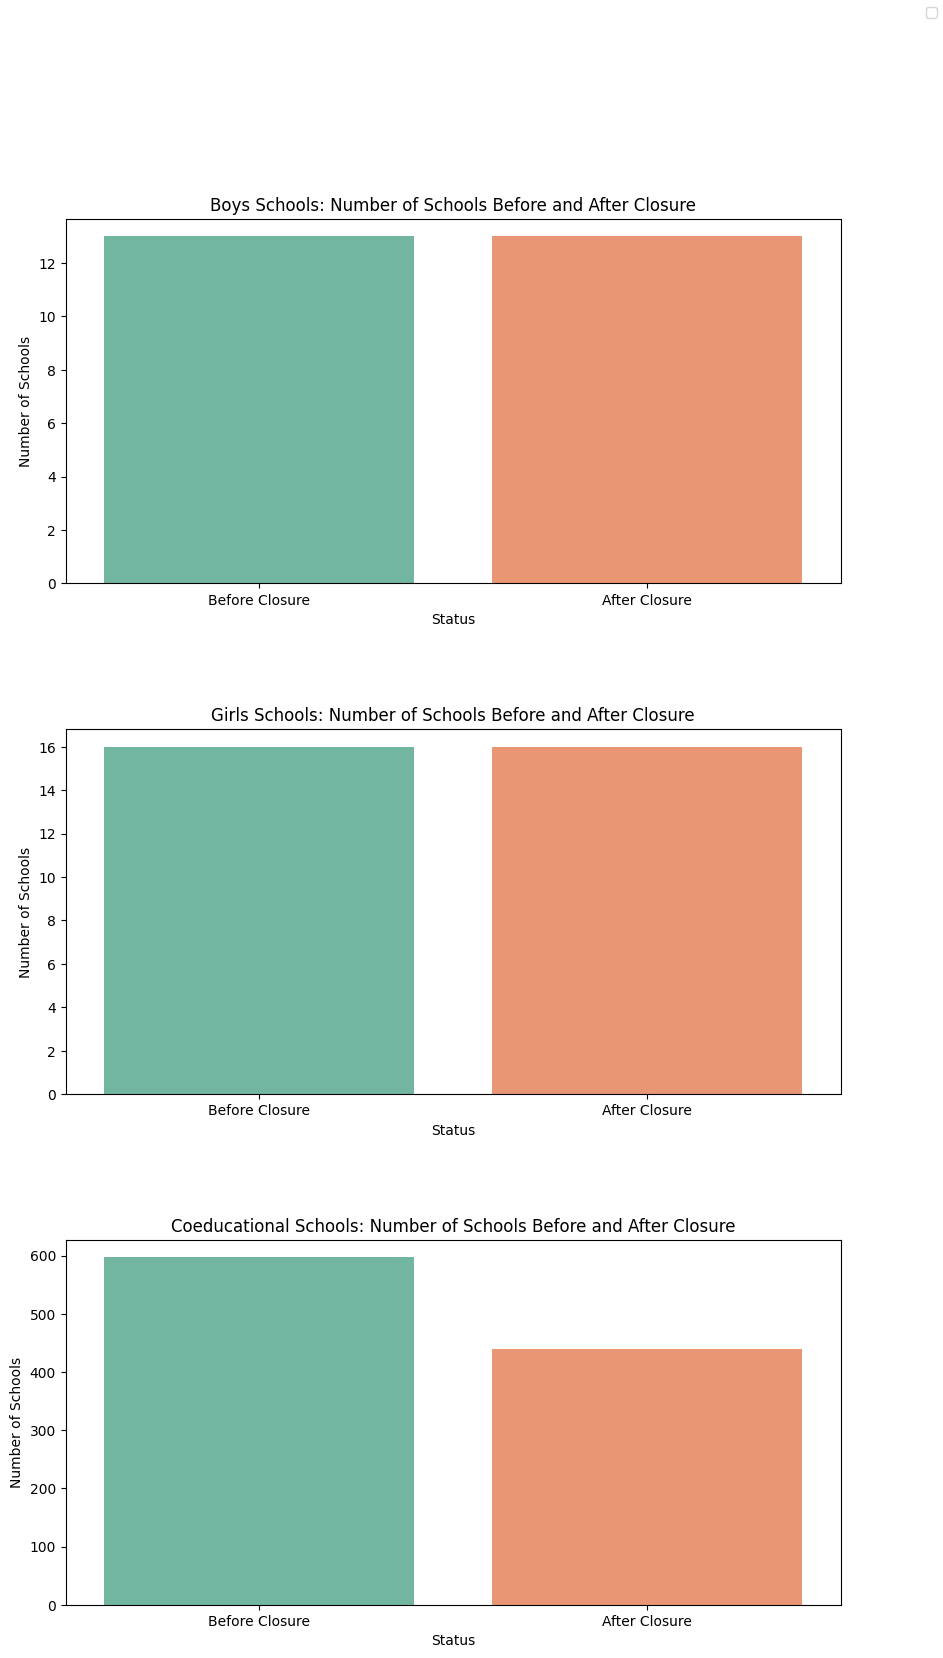

In [13]:
befor_genderschool_count = df['School_gender'].value_counts().reset_index()
after_gendershool_count = df_after['School_gender'].value_counts().reset_index()
befor_genderschool_count.columns = ['School_gender', 'School_Count']
befor_genderschool_count['Status'] = 'Before Closure'
after_gendershool_count.columns = ['School_gender', 'School_Count']
after_gendershool_count['Status'] = 'After Closure'
gender_comparison = pd.concat([befor_genderschool_count, after_gendershool_count])

fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=False)
plt.subplots_adjust(hspace=0.4)
sns.barplot(x='Status', y='School_Count', data=gender_comparison[gender_comparison['School_gender'] == 'Boys'], ax=axes[0], palette='Set2')
axes[0].set_title('Boys Schools: Number of Schools Before and After Closure')
axes[0].set_ylabel('Number of Schools')

sns.barplot(x='Status', y='School_Count', data=gender_comparison[gender_comparison['School_gender'] == 'Girls'], ax=axes[1], palette='Set2')
axes[1].set_title('Girls Schools: Number of Schools Before and After Closure')
axes[1].set_ylabel('Number of Schools')

sns.barplot(x='Status', y='School_Count', data=gender_comparison[gender_comparison['School_gender'] == 'Coed'], ax=axes[2], palette='Set2')
axes[2].set_title('Coeducational Schools: Number of Schools Before and After Closure')
axes[2].set_ylabel('Number of Schools')

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

As for the students number for those three types of schools

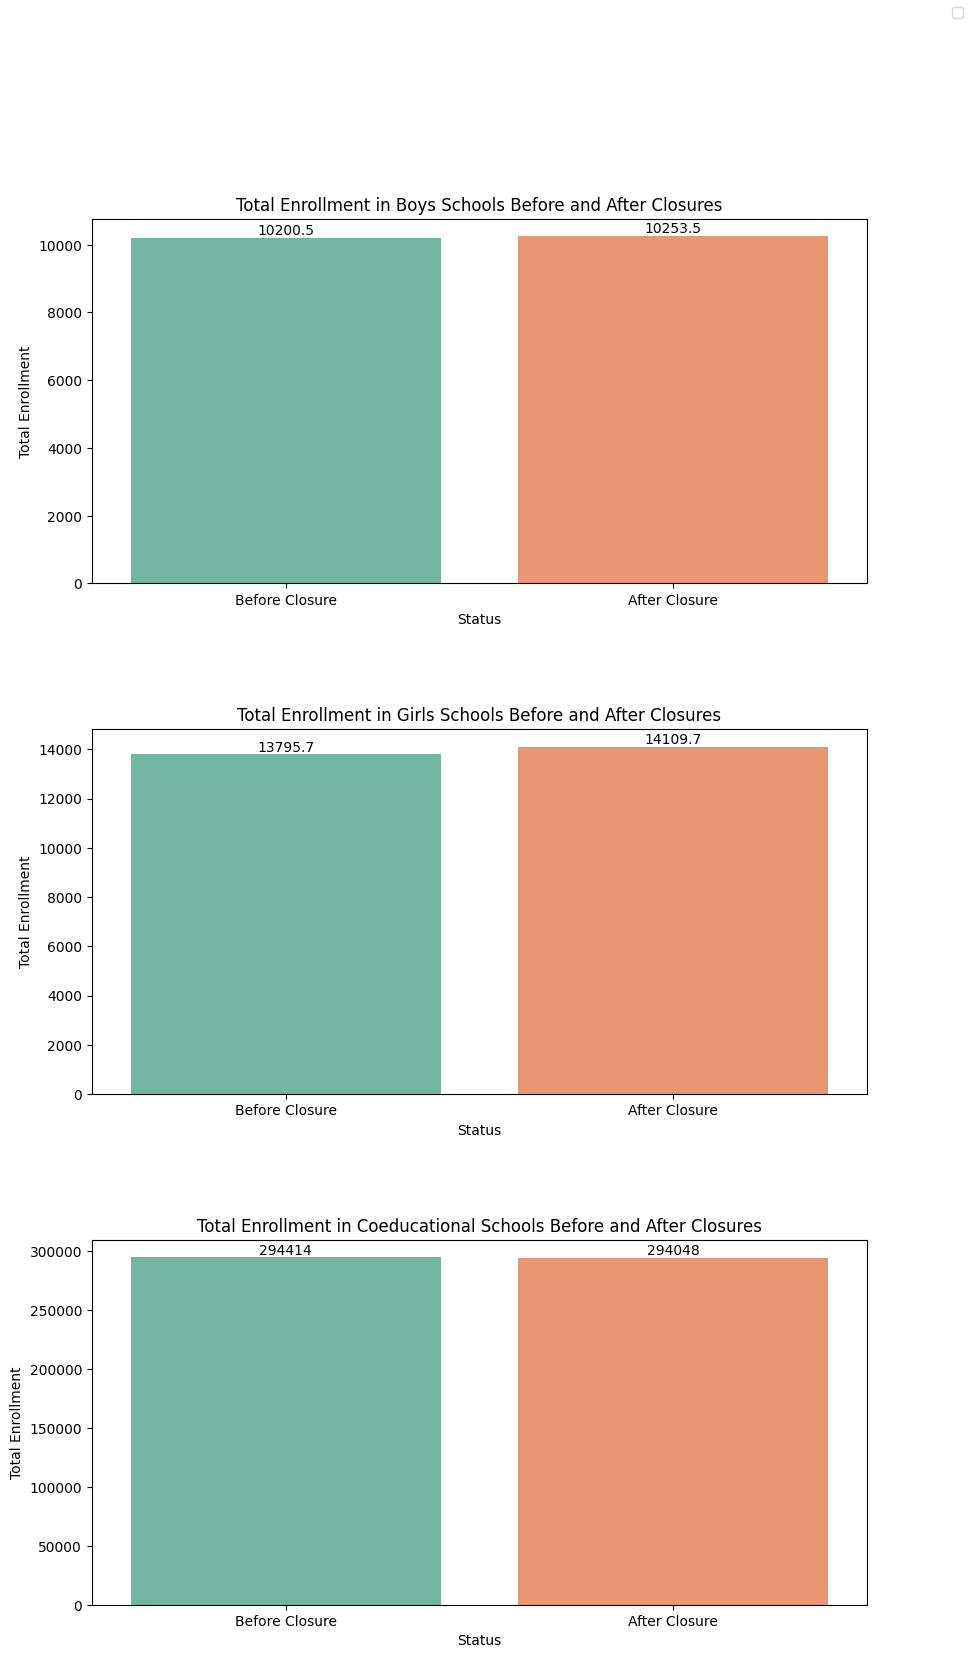

In [14]:
before_genderschool_students = df.groupby('School_gender')['latest_year_enrolment_FTE'].sum().reset_index()
after_genderschool_students = df_after.groupby('School_gender')['latest_year_enrolment_FTE'].sum().reset_index()
before_genderschool_students.columns = ['School_gender', 'Total_Enrollment']
before_genderschool_students['Status'] = 'Before Closure'
after_genderschool_students.columns = ['School_gender', 'Total_Enrollment']
after_genderschool_students['Status'] = 'After Closure'
gender_comparison = pd.concat([before_genderschool_students, after_genderschool_students])


fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=False)
plt.subplots_adjust(hspace=0.4)
boys_plot = sns.barplot(x='Status', y='Total_Enrollment', hue='Status', data=gender_comparison[gender_comparison['School_gender'] == 'Boys'], ax=axes[0], palette='Set2')
axes[0].set_title('Total Enrollment in Boys Schools Before and After Closures')
axes[0].set_ylabel('Total Enrollment')
boys_plot.bar_label(boys_plot.containers[0])
boys_plot.bar_label(boys_plot.containers[1])

girls_plot = sns.barplot(x='Status', y='Total_Enrollment', data=gender_comparison[gender_comparison['School_gender'] == 'Girls'], hue='Status', ax=axes[1], palette='Set2')
axes[1].set_title('Total Enrollment in Girls Schools Before and After Closures')
axes[1].set_ylabel('Total Enrollment')
girls_plot.bar_label(girls_plot.containers[0])
girls_plot.bar_label(girls_plot.containers[1])

coed_plot = sns.barplot(x='Status', y='Total_Enrollment', data=gender_comparison[gender_comparison['School_gender'] == 'Coed'], hue='Status', ax=axes[2], palette='Set2')
axes[2].set_title('Total Enrollment in Coeducational Schools Before and After Closures')
axes[2].set_ylabel('Total Enrollment')
coed_plot.bar_label(coed_plot.containers[0])
coed_plot.bar_label(coed_plot.containers[1])


handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

##2.4KBQ 4:How will this policy affect the different SA4 regions within Sydney?

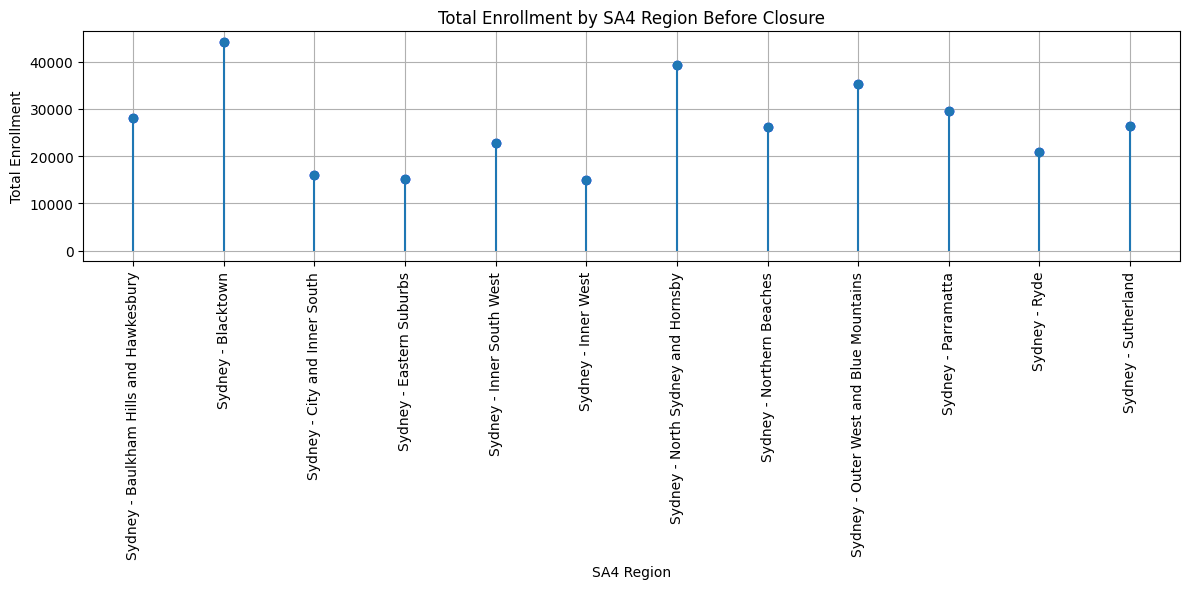

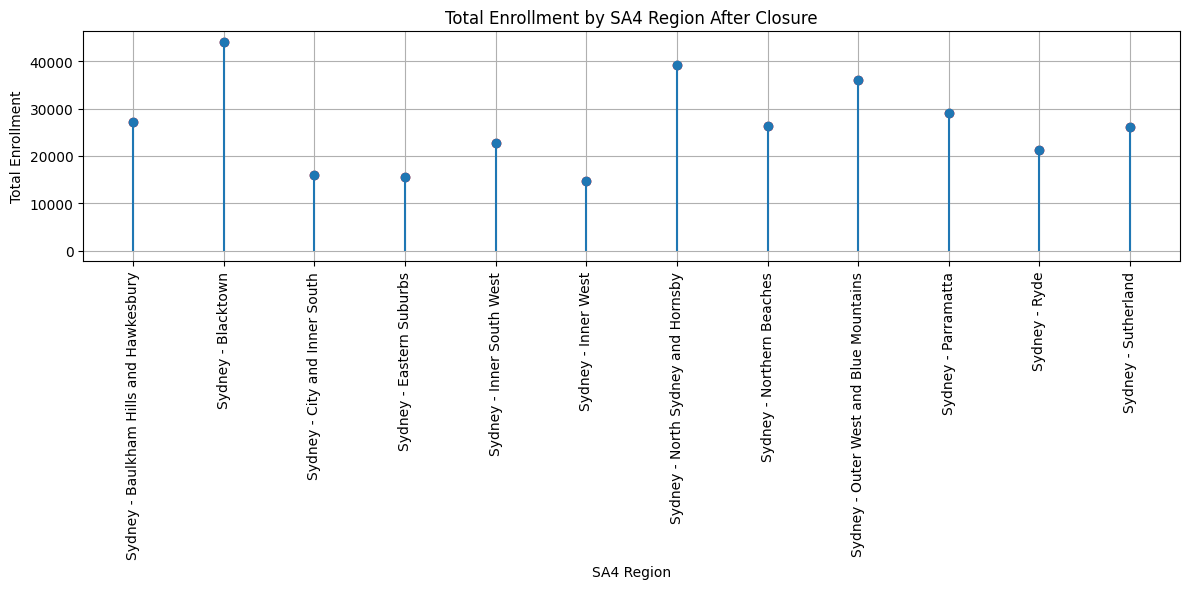

In [15]:


before_sa4 = df.groupby('SA4')['latest_year_enrolment_FTE'].sum().reset_index().sort_values('SA4')
after_sa4 = df_after.groupby('SA4')['latest_year_enrolment_FTE'].sum().reset_index().sort_values('SA4')


plt.figure(figsize=(12, 6))
plt.stem(before_sa4['SA4'], before_sa4['latest_year_enrolment_FTE'], basefmt=" ", use_line_collection=True)
plt.scatter(before_sa4['SA4'], before_sa4['latest_year_enrolment_FTE'], color='blue', label='Before Closure')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.subplots_adjust(bottom=0.25)
plt.xlabel('SA4 Region')
plt.ylabel('Total Enrollment')
plt.title('Total Enrollment by SA4 Region Before Closure')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.stem(after_sa4['SA4'], after_sa4['latest_year_enrolment_FTE'], basefmt=" ", use_line_collection=True)
plt.scatter(after_sa4['SA4'], after_sa4['latest_year_enrolment_FTE'], color='red', label='After Closure')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.subplots_adjust(bottom=0.25)
plt.xlabel('SA4 Region')
plt.ylabel('Total Enrollment')
plt.title('Total Enrollment by SA4 Region After Closure')
plt.grid(True)
plt.tight_layout()
plt.show()





##2.5KBQ 5:Are there any other issues of equity that will be impacted by a policy of closing smaller schools or schools with declining or non-growing enrolments.

<Figure size 1200x600 with 0 Axes>

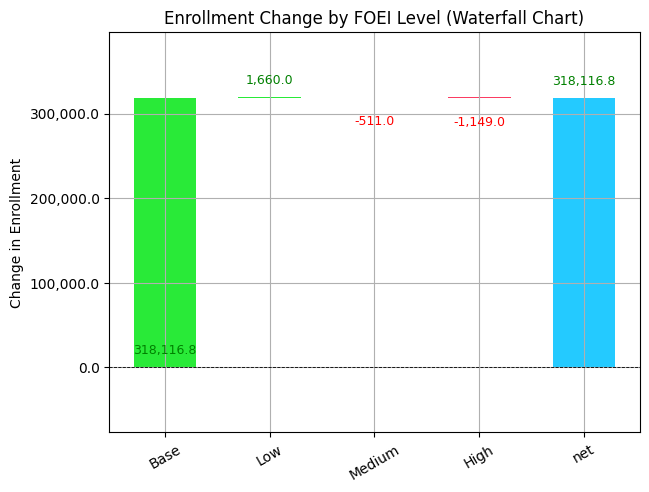

In [16]:
low_threshold, high_threshold = df['FOEI_Value'].quantile([0.333, 0.666])

# 将 FOEI 分为 'Low', 'Medium', 'High' 三个区间
df['FOEI_Level'] = pd.cut(df['FOEI_Value'], bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
                          labels=['Low', 'Medium', 'High'])
df_after['FOEI_Level'] = pd.cut(df_after['FOEI_Value'], bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
                                labels=['Low', 'Medium', 'High'])

# 计算各个 FOEI 区间的学生人数变化
before_foei = df.groupby('FOEI_Level')['latest_year_enrolment_FTE'].sum().reset_index()
after_foei = df_after.groupby('FOEI_Level')['latest_year_enrolment_FTE'].sum().reset_index()

# 计算变化量
foei_change = after_foei.set_index('FOEI_Level')['latest_year_enrolment_FTE'] - before_foei.set_index('FOEI_Level')['latest_year_enrolment_FTE']
waterfall_data = pd.DataFrame({'FOEI_Level': foei_change.index, 'Change': foei_change.values})

# 添加基准点
waterfall_data.loc[-1] = ['Base', before_foei['latest_year_enrolment_FTE'].sum()]
waterfall_data = waterfall_data.sort_index()  # 按 FOEI 顺序排列

# 绘制 Waterfall Chart
plt.figure(figsize=(12, 6))
waterfall_chart.plot(waterfall_data['FOEI_Level'], waterfall_data['Change'])
plt.title('Enrollment Change by FOEI Level (Waterfall Chart)')
plt.ylabel('Change in Enrollment')
plt.grid(True)
plt.show()
